In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
save_filepath = '/Users/andrewwork/Documents/grad-school/thesis/meeting-notes/spring-19/toy-problem/'

# Solving the rolling-only bifurcation problem

To simplify the platelet rolling model, assume that $d = 0$ and $V = R \Omega$. That is, no slip is allowed between the platelet surface and the wall. Then the bond density ($n$) evolution equation simplifies to $$\frac{\partial n}{\partial t} = R\Omega \frac{\partial n}{\partial x} + \Omega \frac{\partial n}{\partial \theta} + \alpha(x, \theta) \left(N_T - \int_{-\infty}^\infty n(x, \theta) dx \right) - \beta(x, \theta) n.$$

We are looking to find steady state rolling velocities and bond distributions as a function of the applied rolling velocity $V_f$, so set $\frac{\partial n}{\partial t} = 0$:
$$0 = R\Omega \frac{\partial n}{\partial x} + \Omega \frac{\partial n}{\partial \theta} + \alpha(x, \theta) \left(N_T - \int_{-\infty}^\infty n(x, \theta) dx \right) - \beta(x, \theta) n,$$
or in nondimensional terms, 
$$0 = \omega \frac{\partial m}{\partial z} + \omega \frac{\partial m}{\partial \theta} + \alpha'(z, \theta) \left(1 - \int_{-\infty}^\infty m(z, \theta) dz \right) - \beta'(z, \theta) m.$$

We can write evolution equations for the coordinates $z$ and $\theta$ using the rolling velocities: $$\frac{dz}{dt} = \frac{d\theta}{dt} = -\omega$$ 

Therefore, $z(t) = -\omega t + z_0$ and $\theta(t) = -\omega t + \theta_0$, then eliminating $t$ we get $\theta(z) = z + \theta_0 - z_0$. Let's say we can define a density function $\hat{m}$ that only varies as a function of $z$: $\hat{m}(z) = m(z, \theta(z))$. Then note what happens when we take a derivative of $\hat{m}$:
$$\frac{d\hat{m}}{dz} = \frac{\partial m}{\partial z} + \frac{\partial m}{\partial \theta} \frac{d \theta}{dz} = \frac{\partial m}{\partial z} + \frac{\partial m}{\partial\theta}.$$

Multiplying through by $-\omega$, we get the following:
$$-\omega\frac{d\hat{m}}{dz} = -\omega \frac{\partial m}{\partial z} - \omega\frac{\partial m}{\partial\theta} = \alpha'(z, \theta(z)) \left(1 - \int_{-\infty}^{\infty} m(z, \theta(z)) dz \right) - \beta'(z, \theta(z)) m $$ $$= \alpha'(z, \theta(z)) \left(1 - \int_{-\infty}^{\infty} \hat{m}(z) dz \right) - \beta'(z, \theta(z)) \hat{m}.$$

If you believe the work above, we have simplified an integro-differential equation in two variables to an IDE in one variable.

## Solving the IDE for $\hat{m}$

From above, we have
$$-\omega\frac{d\hat{m}}{dz} = \hat{\alpha}'(z) \left(1 - \int_{-\infty}^{\infty} \hat{m}(z) dz \right) - \hat{\beta}'(z) \hat{m}.$$

This can be solved with the following procedure:

1. Pick a value $I \in [0, 1)$

2. Solve the ODE $-\omega\frac{dm'}{dz} = \hat{\alpha}'(z) \left(1 - I \right) - \hat{\beta}'(z) m'$

3. Define $I' = \int_{-\infty}^{\infty} m'(x) dx$

4. Then $\hat{m}(x) = m'(x)/(1 - I + I')$

To see that $\hat{m}(z)$ solves the IDE, substitute $m'(z)/(1 - I + I')$ into the IDE above:
$$-\omega \frac{d\hat{m}}{dz} = -\frac{\omega}{1 - I + I'}\frac{dm'(z)}{dz} = \frac{\hat{\alpha}'}{1 - I + I'}(1 - I) - \hat{\beta}'\frac{m'}{1 - I + I'}.$$

Clearly the 2nd term on the RHS is just $\hat{\beta}'(z) \hat{m}$. The 1st term on the RHS simplifies to $\hat{\alpha}' \left(1 - \frac{I'}{1 - I + I'}\right)$. Note that from the definition of $I'$, $\frac{I'}{1 - I + I'} = \int_{-\infty}^{\infty} \hat{m}(z) dz$. Therefore $\hat{m}(z)$ solves the IDE.

The Python code below solves the IDE for $\omega = 10$ and plots the result using this procedure using $I = 0$.

In [2]:
# Define parameters in the problem
kappa = 1.
eta = 0.1
delta = 3.
xi = 1e-3
omega = 10.

In [3]:
# Define functions to evaluate the RHS of the ODE in step 2
def on(length):
    return kappa*np.exp(-eta/2*length**2)

def off(length):
    return np.exp(delta*length)

def func(z, m, om):
    length = np.sqrt((1 - np.cos(z))**2 + (np.sin(z) - z)**2)
    return (on(length) - off(length)*m)/om

In order to mirror Dr. Keener's code, augment the ODE with functions to integrate $m'$ and $\tau$. That is, the code solves the system
$$\frac{d\mathbf{y}}{dz} = \mathbf{F}(z, \mathbf{y}(z)) \text{ where } \mathbf{y} = \begin{pmatrix} m' \\ M \\ T \end{pmatrix} \text{ and } \mathbf{F} = \begin{pmatrix} \hat{\alpha}'(z) \left(1 - I \right) - \hat{\beta}'(z) m' \\ m' \\ \tau \end{pmatrix}.$$

$M$ and $T$ accumulate the bond number and torque, respectively, and $\tau = -[(1 - \cos(z))\sin(z) + (\sin(z) - z)\cos(z)]m'(z)$.

In [4]:
def F(z, y, om):
    m_prime = y[0]
    
    dm_prime = func(z, m_prime, om)
    dM = m_prime
    dT = -((1 - np.cos(z))*np.sin(z) + (np.sin(z) - z)*np.cos(z))*m_prime
    
    return np.array([dm_prime, dM, dT])

In [5]:
z_span = np.linspace(-np.pi/2, np.pi/2)
sol = solve_ivp(lambda z, y: F(z, y, omega), (-np.pi/2, np.pi/2),
                [0, 0, 0], t_eval=z_span)

The plot below shows the function $m'(z)$.

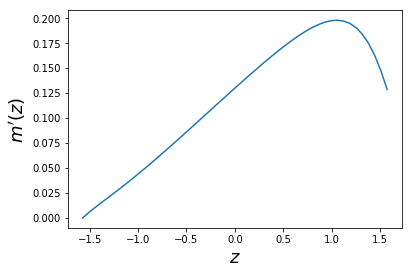

In [6]:
plt.plot(sol.t, sol.y[0].T)
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$m\'(z)$', fontsize=18)
plt.show()

In [7]:
np.savetxt(save_filepath+'unscaled.dat', np.vstack([sol.t, sol.y]).T,
           delimiter=',', header='t,m_prime,M,torque', comments='')

The final value of $M$ is just $I'$, and the final value of $T$ is the total torque:

In [8]:
I_prime = sol.y[1, -1]
print(I_prime)
print(-sol.y[2, -1])

0.37034787808462916
0.0643654132900808


Finally, $\hat{m}$ is found by dividing $m'$ by $1 + I'$:

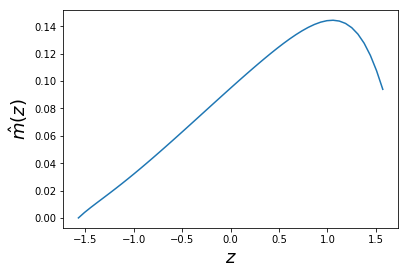

In [9]:
m_hat = sol.y[0].T/(1 + I_prime)
plt.plot(z_span, m_hat)
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$\\hat{m}(z)$', fontsize=18)
plt.show()

In [10]:
np.savetxt(save_filepath+'scaled.dat', np.vstack([sol.t, m_hat]).T, delimiter=',', comments='')

We can check that $\hat{m}$ satisfies the original IDE:

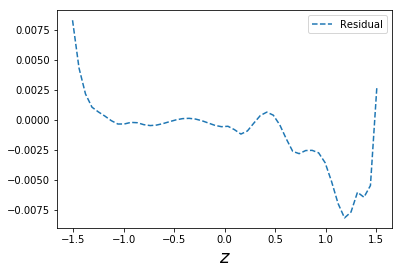

The maximum absolute error is 0.0082739


In [11]:
dm_hat = (m_hat[2:] - m_hat[:-2]).T/(z_span[2:] - z_span[:-2])
I_hat = np.trapz(m_hat.T, z_span)
length_span = np.sqrt((1 - np.cos(z_span))**2 + (np.sin(z_span) - z_span)**2)
error = omega*dm_hat - (on(length_span[1:-1])*(1 - I_hat)
                           - off(length_span[1:-1])*m_hat[1:-1].T)
plt.plot(z_span[1:-1], omega*dm_hat.T - (on(length_span[1:-1])*(1 - I_hat)
                        - off(length_span[1:-1])*m_hat[1:-1].T).T,
         '--')
plt.xlabel('$z$', fontsize=18)
plt.legend(['Residual'])
plt.show()
print('The maximum absolute error is {:g}'.format(np.max(error)))

## Generating a bifurcation diagram

We can use the above approach to generate a bifurcation diagram in the parameter $\omega_f$. We choose a bunch of $\omega$ values, solve for the steady state bond distribution, calculate the torque generated at steady state, and finally solve for $\omega_f$.

In [12]:
# Generate a list of omegas at which to calculate torques
omegas = 0.0001 + np.arange(start=1, stop=301)/3

In [13]:
# Initialize a list of torques
torques = np.zeros(shape=omegas.shape)
tot_bonds = np.zeros(shape=omegas.shape)

In [14]:
for j, omega in enumerate(omegas):
    sol = solve_ivp(lambda z, y: F(z, y, omega), (-np.pi/2, np.pi/2),
                    [0, 0, 0], t_eval=z_span)
    I_prime = sol.y[1, -1]
    torques[j] = sol.y[2, -1]/(1 + I_prime)
    tot_bonds[j] = I_prime/(1 + I_prime)

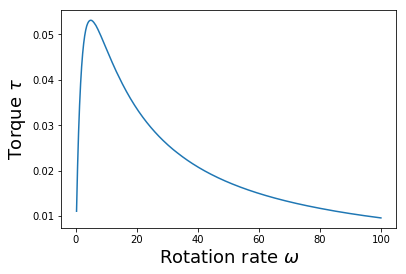

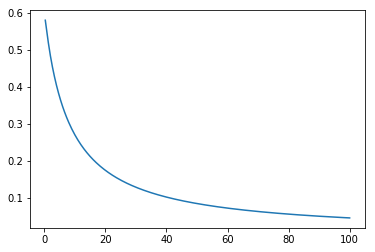

In [15]:
plt.plot(omegas, -torques)
plt.xlabel('Rotation rate $\\omega$', fontsize=18)
plt.ylabel('Torque $\\tau$', fontsize=18)
plt.show()
plt.plot(omegas, tot_bonds)
plt.show()

In [16]:
np.savetxt(save_filepath+'om_vs_tau.dat', np.vstack([omegas, -torques]).T, delimiter=',')

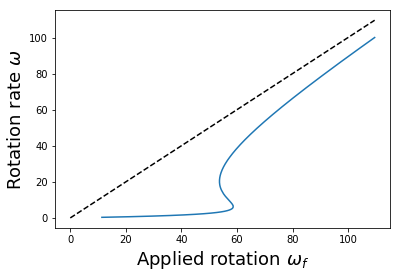

In [17]:
m = np.amax(omegas - torques/xi)
plt.plot(omegas - torques/xi, omegas)
plt.plot([0, m], [0, m], '--k')
plt.xlabel('Applied rotation $\\omega_f$', fontsize=18)
plt.ylabel('Rotation rate $\\omega$', fontsize=18)
plt.show()

In [18]:
np.savetxt(save_filepath+'omf_vs_om.dat', np.vstack([omegas - torques/xi, omegas]).T, delimiter=',')

The results above match results of Dr. Keener's Matlab code, at least in the eyeball test.

## Comparison with the 2D steady state problem

In [19]:
from steady_state import steady_state_sweep
from utils import construct_system
from scipy.sparse.linalg import spsolve

In [20]:
M, N = 100, 100
L = 2.5
z_mesh, th_mesh = np.meshgrid(np.linspace(-L, L, 2*M+1),
                              np.linspace(-np.pi/2, np.pi/2, N+1),
                              indexing='ij')
z_vec, th_vec = np.ravel(z_mesh, order='F'), np.ravel(th_mesh, order='F')
h = z_mesh[1, 0] - z_mesh[0, 0]
nu = th_mesh[0, 1] - th_mesh[0, 0]

In [21]:
A, B, C, D, R = construct_system(M, N, eta, z_vec, th_vec, delta, nu, kappa, scheme='up', saturation=False)
m = spsolve(omega*A + omega*B + h*nu*kappa*C + nu*D, -R)
m_mesh = m.reshape(2*M+1, -1, order='F')

0.01677752049496902
2
0.01677752049496902 -2.45 -1.5707963267948966


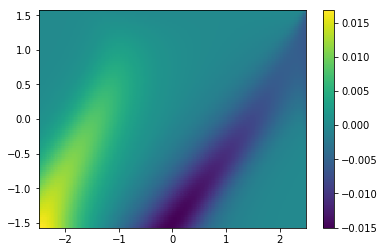

In [22]:
residual = (omega*(A + nu/h*B) + h*nu*kappa*C + nu*D).dot(m) + R
print(np.abs(residual).max())
rm = np.argmax(residual)
print(rm)
print(residual[rm], z_vec[rm], th_vec[rm])
r_mesh = residual.reshape(2*M+1, -1, order='F')
plt.pcolormesh(z_mesh, th_mesh, r_mesh)
plt.colorbar()
plt.show()

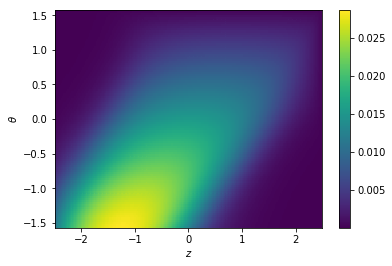

In [23]:
plt.pcolormesh(z_mesh, th_mesh, m_mesh)
plt.xlabel('$z$')
plt.ylabel('$\\theta$')
plt.colorbar()
plt.show()

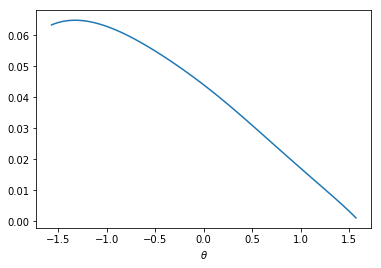

In [24]:
plt.plot(th_mesh[0,:], np.trapz(m_mesh, z_mesh, axis=0))
plt.xlabel('$\\theta$')
plt.show()

In [25]:
l_mesh = np.sqrt((1 - np.cos(th_mesh))**2 + (np.sin(th_mesh) - z_mesh)**2)
RHS = (kappa*np.exp(-eta/2*l_mesh[:-1, :-1]**2)
       * (1 - np.tile(np.trapz(m_mesh[:, :-1], dx=h, axis=0), reps=(m_mesh.shape[0]-1, 1)))
       - np.exp(delta*l_mesh[:-1, :-1])*m_mesh[:-1, :-1]
      )
dmdz = (m_mesh[1:, :-1] - m_mesh[:-1, :-1])/(z_mesh[1:, :-1] - z_mesh[:-1, :-1])
dmdth = (m_mesh[:-1, 1:] - m_mesh[:-1, :-1])/(th_mesh[:-1, 1:] - th_mesh[:-1, :-1])

LHS = -omega*(dmdz + dmdth)
print(RHS.shape, LHS.shape)

(200, 100) (200, 100)


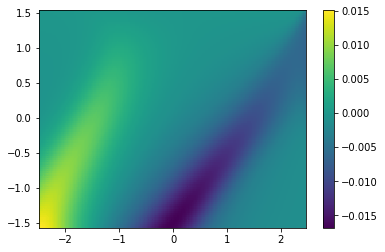

In [26]:
plt.pcolormesh(z_mesh[:-1, :-1], th_mesh[:-1, :-1], nu*(RHS-LHS))
plt.colorbar()
plt.show()

In [27]:
error = np.sqrt(np.trapz(np.trapz(LHS - RHS**2, dx=h, axis=0), dx=nu, axis=0))
mtot = np.trapz(np.trapz(m_mesh, dx=h, axis=0), dx=nu, axis=0)
print(mtot, error*nu)

0.1272579651696201 0.04200161627662425


Completed 1 of 101 loops
Completed 2 of 101 loops
Completed 3 of 101 loops
Completed 4 of 101 loops
Completed 5 of 101 loops
Completed 6 of 101 loops
Completed 7 of 101 loops
Completed 8 of 101 loops
Completed 9 of 101 loops
Completed 10 of 101 loops
Completed 11 of 101 loops
Completed 12 of 101 loops
Completed 13 of 101 loops
Completed 14 of 101 loops
Completed 15 of 101 loops
Completed 16 of 101 loops
Completed 17 of 101 loops
Completed 18 of 101 loops
Completed 19 of 101 loops
Completed 20 of 101 loops
Completed 21 of 101 loops
Completed 22 of 101 loops
Completed 23 of 101 loops
Completed 24 of 101 loops
Completed 25 of 101 loops
Completed 26 of 101 loops
Completed 27 of 101 loops
Completed 28 of 101 loops
Completed 29 of 101 loops
Completed 30 of 101 loops
Completed 31 of 101 loops
Completed 32 of 101 loops
Completed 33 of 101 loops
Completed 34 of 101 loops
Completed 35 of 101 loops
Completed 36 of 101 loops
Completed 37 of 101 loops
Completed 38 of 101 loops
Completed 39 of 101 l

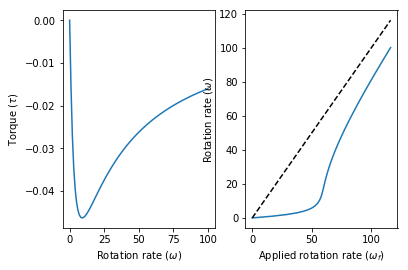

In [28]:
om_f, om2d, tq2d = steady_state_sweep(d_prime=0, eta=eta, delta=delta, om_max=100, om_number=101, eta_om=xi,
                                      saturation=True)

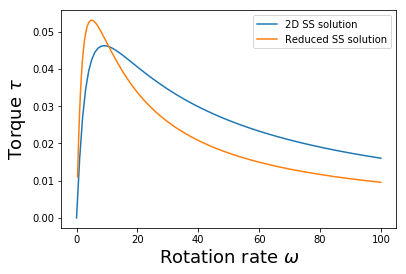

In [29]:
plt.plot(om2d, -tq2d, omegas, -torques)
plt.legend(['2D SS solution', 'Reduced SS solution'])
plt.xlabel('Rotation rate $\\omega$', fontsize=18)
plt.ylabel('Torque $\\tau$', fontsize=18)
plt.show()

In [30]:
np.savetxt(save_filepath+'om_vs_tau2d.dat', np.vstack([om2d, -tq2d]).T, delimiter=',')

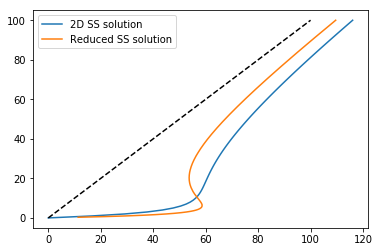

In [31]:
plt.plot(om_f, om2d)
plt.plot(omegas - torques/xi, omegas)
mm = np.amax(om2d)
plt.plot([0, mm], [0, mm], '--k')
plt.legend(['2D SS solution', 'Reduced SS solution'])
plt.show()

In [32]:
np.savetxt(save_filepath+'omf_vs_om2d.dat', np.vstack([om_f, om2d]).T, delimiter=',')

## Some other toy problems

### Platelet rolling with a large number of receptors
Since Dr. Keener's original reduction is wrong, we want to try something else. It's not clear there's a way to reduce the full model with saturation, so something to try is to eliminate the saturation term (i.e. the integral over $z$). We are looking for regions in parameter space where the number of bonds is small anyway, so maybe saturation isn't important in that region anyways. (Caveat: we are looking for regions where $\pi >> \int \int m(z, \theta) dz d\theta$, which is not necessarily the same as $1 >> \int m(z, \theta) dz$ for all $\theta$).

Now we are solving the equation 
$$0 = \omega \frac{\partial m}{\partial z} + \omega \frac{\partial m}{\partial \theta} + \alpha(z, \theta) - \beta(z, \theta).$$

We can solve this with the method of characteristics easily enough. Define characteristics as a function of a parameter $s \in [0, \pi/\omega]$: $z(s) = z_0 - \omega s$ and $\theta(s) = \pi/2 - \omega s$. Then define $\tilde{m}(s, z_0) \equiv m(z_0 - \omega s, \pi/2 - \omega s$. Taking an $s$ derivative of $\tilde{m}$,
$$\frac{d \tilde{m}}{ds} = \frac{\partial m}{\partial z}\frac{dz}{ds} + \frac{\partial m}{\partial \theta}\frac{d\theta}{ds} = -\omega \left(\frac{\partial m}{\partial z} + \frac{\partial m}{\partial \theta}\right) = \alpha(z(s, z_0), \theta(s)) - \beta(z(s, z_0), \theta(s)) \tilde{m}(s, z_0).$$

Therefore, to find $m(z, \theta)$ we have to solve the ODE
$$\frac{d\tilde{m}}{ds}(s;z_0) = \tilde{\alpha}(s; z_0) - \tilde{\beta}(s; z_0) m(s; z_0), \quad s \in [0, \pi/\omega], \quad m(0; z_0) = 0$$
where $z_0 = (z + (\pi - 2\theta)/2)$ and then evaluate $\tilde{m}$ at $s = (\pi - 2\theta)/(2\omega)$. This ODE might be simplified further.

In [33]:
from scipy.integrate import quad, quad_explain
from scipy.integrate import cumtrapz, simps, trapz
from timeit import default_timer as timer
from matplotlib.colors import LogNorm

In [34]:
def z_fn(s, z_0):
    return z_0 - np.pi*s
def th_fn(s):
    return np.pi/2 - np.pi*s

In [35]:
# def func(s, m, z_0):
#     length = np.sqrt((1 - np.cos(th_fn(s)))**2 + (np.sin(th_fn(s)) - z_fn(s, z_0))**2)
#     return on(length) - off(length)*m

In [36]:
def on(length, kappa, eta, delta):
    return kappa*np.exp(-eta/2*length**2)/np.sqrt(2*np.pi/eta)

def off(length, kappa, eta, delta):
    return np.exp(delta*length)

In [37]:
def solve_along_chars(z_0, omega, kappa, eta, delta):
    s_vec = np.linspace(0, 1, num=1001)
    h = s_vec[1] - s_vec[0]
    s_vec = s_vec[:, None, None]
    z_0 = z_0[None, :, None]
    omega = omega[None, None, :]
    
    len_arr = np.sqrt((1 - np.cos(th_fn(s_vec)))**2 + (np.sin(th_fn(s_vec)) - z_fn(s_vec, z_0))**2)
    tau_arr = -((1 - np.cos(th_fn(s_vec)))*np.sin(th_fn(s_vec))
                + (np.sin(th_fn(s_vec)) - z_fn(s_vec, z_0))*np.cos(th_fn(s_vec)))
    
    on_arr, off_arr = on(len_arr, kappa, eta, delta), off(len_arr, kappa, eta, delta)
    m_arr = np.zeros(shape=(s_vec.shape[0], z_0.shape[1], omega.shape[2]))
    
    for i in range(0, m_arr.shape[0]-1):
        m_arr[i+1] = ((m_arr[i] - np.pi*h/(2*omega)*(off_arr[i]*m_arr[i] - on_arr[i] - on_arr[i+1]))
                      /(1+ np.pi*h*off_arr[i+1]/(2*omega)))
    M = np.pi*trapz(trapz(m_arr, z_0, axis=1), dx=h, axis=0)
    T = np.pi*trapz(trapz(tau_arr*m_arr, z_0, axis=1), dx=h, axis=0)
    
    return M, T

4.723352219999995


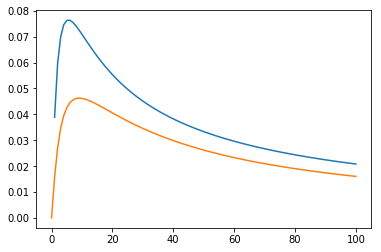

In [38]:
z_0 = np.linspace(-5, 5, num=1001)
omegas = np.linspace(0, 100, num=101)[1:]
start = timer()
M, T = solve_along_chars(z_0, omegas, 7.9, .1, 3)
end = timer()
print(end - start)
plt.plot(omegas, T, om2d, -tq2d)
plt.show()

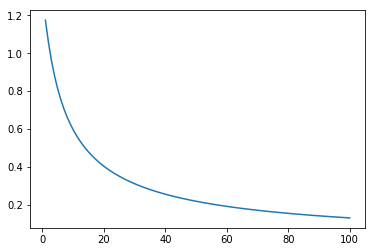

In [39]:
plt.plot(omegas, M)
plt.show()

In [40]:
np.savetxt(save_filepath+'chars_om_M_T.dat', np.vstack([omegas, M, T]).T, delimiter=',')

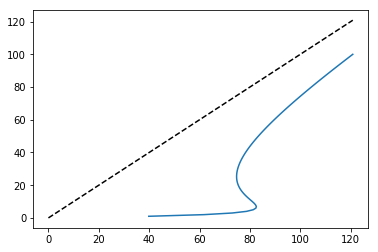

In [41]:
plt.plot(omegas + T/xi, omegas)
m = np.amax(omegas + T/xi)
plt.plot([0, m], [0, m], 'k--')
plt.show()

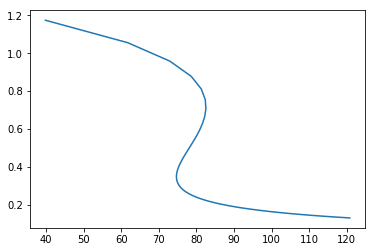

In [42]:
plt.plot(omegas + T/xi, M)
plt.show()

In [43]:
np.savetxt(save_filepath+'chars_omf_om_M.dat', np.vstack([omegas + T/xi, omegas, M]).T, delimiter=',')

In [44]:
np.vstack([omegas + T/xi, omegas, M]).T

array([[ 39.83723646,   1.        ,   1.17400796],
       [ 61.72264046,   2.        ,   1.05557272],
       [ 72.96189206,   3.        ,   0.95800262],
       [ 78.61698384,   4.        ,   0.87792552],
       [ 81.30059504,   5.        ,   0.81130214],
       [ 82.3660053 ,   6.        ,   0.75505758],
       [ 82.53781634,   7.        ,   0.70693291],
       [ 82.21841293,   8.        ,   0.66526183],
       [ 81.63835984,   9.        ,   0.62879875],
       [ 80.93295274,  10.        ,   0.59659797],
       [ 80.1828098 ,  11.        ,   0.56793019],
       [ 79.43624276,  12.        ,   0.54222457],
       [ 78.72201796,  13.        ,   0.51902815],
       [ 78.05685662,  14.        ,   0.49797695],
       [ 77.44995814,  15.        ,   0.47877509],
       [ 76.9057879 ,  16.        ,   0.46117955],
       [ 76.42582701,  17.        ,   0.44498879],
       [ 76.00968694,  18.        ,   0.43003421],
       [ 75.65582762,  19.        ,   0.41617364],
       [ 75.36202388,  20.     

In [45]:
def parameter_sweep(kap_vec, eta_vec, del_vec):
    z_0 = np.linspace(-5, 5, num=1001)
    omegas = np.linspace(0, 100, num=101)[1:]
    
    M = np.zeros(shape = kap_vec.shape + eta_vec.shape + del_vec.shape + omegas.shape)
    T = np.zeros(shape = kap_vec.shape + eta_vec.shape + del_vec.shape + omegas.shape)
    for (i, kappa) in enumerate(kap_vec):
        for (j, eta) in enumerate(eta_vec):
            for (k, delta) in enumerate(del_vec):
                M[i, j, k], T[i, j, k] = solve_along_chars(z_0, omegas, kappa, eta, delta)
    return omegas, M, T

In [46]:
kap_vec = np.logspace(-1, 3, num=5)
eta_vec = np.logspace(2, 5, num=5)
del_vec = np.linspace(.5, 2, num=5)
kap_msh, kap_mid = kap_vec[::2], kap_vec[1::2]
eta_msh, eta_mid = eta_vec[::2], eta_vec[1::2]
del_msh, del_mid = del_vec[::2], del_vec[1::2]
start = timer()
omegas, M, T = parameter_sweep(kap_mid, eta_mid, del_mid)
end = timer()

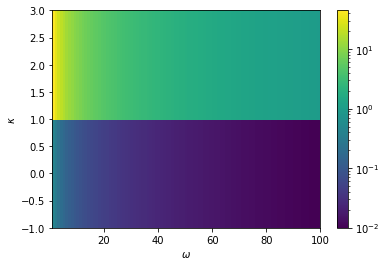

[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


In [47]:
omegas = np.linspace(0, 100, num=101)[1:]
plt.pcolormesh(omegas, np.log10(kap_msh), M[:, 0, 0, :], norm=LogNorm())
plt.xlabel('$\\omega$')
plt.ylabel('$\\kappa$')
plt.colorbar()
plt.show()
print(kap_vec)

### Platelet rolling with restricted bond formation
Another possible simplification is to assume $\eta >> 1$ and approximate $\alpha(z, \theta) \approx \kappa\delta(z, \theta)$. Then, 
$0 = \omega \frac{\partial m}{\partial z} + \omega \frac{\partial m}{\partial \theta} + \kappa \delta(z, \theta) (1 - \int m(z, \theta) dz) - \beta(z, \theta) m(z, \theta)$. How to handle this? Integrate over the domain and see what happens?